# Location detection

The task is to detect location names from ukrainian and russian texts.

In [ ]:
!pip install datasets transformers evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f50eed64ee216b50a1a421a06bd8efc361315940b8b201a7f52677b2964

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

import os
import re
import spacy
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import precision_recall_curve, auc
from torch import nn
from torchtext.vocab import build_vocab_from_iterator
import string
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from transformers import TrainingArguments, get_linear_schedule_with_warmup
from transformers import Trainer, pipeline

In [ ]:
!python -m spacy download uk_core_news_sm

2023-10-29 12:16:09.809983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 12:16:09.810039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 12:16:09.810079: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 12:16:10.986686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 620.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.6 MB/s eta 0:00

In [ ]:
global_device = 'cpu'

if torch.cuda.is_available():
    global_device = 'cuda'

DATA_DIR = "data/"

## Load data

In [ ]:
uk_dataset = pd.read_csv(DATA_DIR + "uk_geo_dataset.csv", converters={'loc_markers': eval})
ru_dataset = pd.read_csv(DATA_DIR + "ru_geo_dataset.csv", converters={'loc_markers': eval})

In [ ]:
uk_dataset.head()

In [ ]:
ru_dataset.head()

## EDA

In [ ]:
uk_dataset['location_count'] = uk_dataset['loc_markers'].apply(len)
ru_dataset['location_count'] = ru_dataset['loc_markers'].apply(len)

NameError: name 'ru_dataset' is not defined

In [ ]:
def get_locations(row):
    text, loc_markers = row['text'], row['loc_markers']
    return [text[s:e] for s, e in loc_markers]

print(uk_dataset[uk_dataset['location_count'] >= 1].iloc[1]['text'])
print(get_locations(uk_dataset[uk_dataset['location_count'] >= 1].iloc[1]))
print(ru_dataset.iloc[1]['text'])
print(get_locations(ru_dataset.iloc[1]))

In [ ]:
uk_dataset.shape[0]

In [ ]:
ru_dataset.shape[0]

In [ ]:
fig, (uk_dist, ru_dist) = plt.subplots(1, 2, figsize=(15, 5))

uk_dist.title.set_text('Uk dataset location count distribution')
uk_dist.plot(uk_dataset['location_count'].value_counts(normalize=True))

ru_dist.title.set_text('Ru dataset location count distribution')
ru_dist.plot(ru_dataset['location_count'].value_counts(normalize=True))
plt.show()

print("Uk_dataset:")
print(uk_dataset['location_count'].value_counts())
print("Ru_dataset:")
ru_dataset['location_count'].value_counts()

In [ ]:
locations = uk_dataset.apply(get_locations, axis=1)

result = []
for x in locations.to_list():
    for l in x:
        result.append(l)

pd.Series(result).value_counts()

In [ ]:
ru_dataset['doc_id'].value_counts()

## Evaluation

Using metric function from kaggle competition:

In [ ]:
def process_text(text):
    text = re.sub(r'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower()

def metric(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([process_text(s) for s in y_true_sample])
        y_pred_sample = set([process_text(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp+fn)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2*precision*recall/(precision+recall)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Data preparation

To mark loaction using two tokens: begining of location (B-LOC) and inside of location (I-LOC).

This is necesary, because with using only one LOC token two different locations and one location with two words in it would look the same.

In [ ]:
nlp = spacy.load('uk_core_news_sm', disable=['tagger', 'parser', 'ner', 'texcat'])

def tokenize(texts, all_texts_loc_markers, tokenizer, batch_size=128, n_process=-1):
    all_texts_tokenized = list(tokenizer.pipe(texts, batch_size=batch_size, n_process=n_process))

    result_tokens = []
    result_labels = []
    for tokenized_text, loc_markers in zip(all_texts_tokenized, all_texts_loc_markers):
        tokens = [token.text for token in tokenized_text]
        labels = ['O'] * len(tokenized_text)

        for idx, token in enumerate(tokenized_text):
            for start, end in loc_markers:
                if token.idx >= start and token.idx + len(token.text) <= end:
                    if token.idx == start:
                        # If token start pos == marker start,
                        # then it is begining of new location name
                        labels[idx] = 'B-LOC'
                    else:
                        # If token start pos > marker start,
                        # then it is inside of location name
                        labels[idx] = 'I-LOC'
        result_tokens.append(tokens)
        result_labels.append(labels)

    return result_tokens, result_labels

In [ ]:
def process_dataset(dataset, result_path, add_col=None, n_splits=100):
    try:
        os.remove(result_path)
    except OSError:
        pass

    for split in tqdm(np.array_split(dataset, n_splits), total=n_splits, bar_format='{l_bar}{bar:100}{r_bar}'):
        tokens, labels = tokenize(split['text'].to_list(), split['loc_markers'].to_list(), nlp)
        if add_col is not None:
            result_df = pd.DataFrame({'tokens': tokens, 'labels': labels, add_col: split[add_col].to_list()})
        else:
            result_df = pd.DataFrame({'tokens': tokens, 'labels': labels})
        if not os.path.isfile(result_path):
            result_df.to_parquet(result_path, engine='fastparquet')
        else:
            result_df.to_parquet(result_path, engine='fastparquet', append=True)

    # Save fastparquet as pyarrow
    result_df = pd.read_parquet(result_path, engine='fastparquet')
    result_df.to_parquet(result_path)

## Cross validation splits

Split dataset into train, test and validation.

Uk dataset will be stratified by location count and ru dataset will be groupd by document id

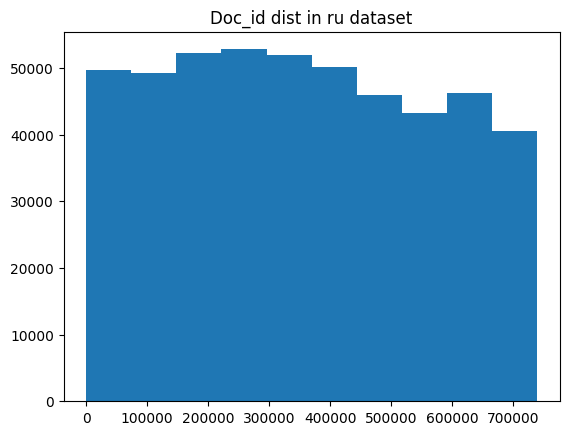

In [ ]:
ru_doc_id_dist = ru_processed_dataset_df['doc_id'].value_counts()
plt.title("Doc_id dist in ru dataset")
plt.hist(dict(ru_doc_id_dist))
plt.show();

Examples in ru dataset with doc_id bigger then 700000 will be used as holdout

In [ ]:
uk_dataset['location_count'] = uk_dataset['loc_markers'].apply(len)
uk_dataset.loc[uk_dataset['location_count'] >= 10, 'location_count'] = -1
uk_dataset['location_count'].value_counts()

location_count
 0    776579
 1    161061
 2     48937
 3     14815
 4      4907
 5      1979
 6       842
 7       401
 8       219
-1       133
 9       127
Name: count, dtype: int64

Using fraction of train set to iterate faster:

In [ ]:
uk_train_dataset = uk_dataset[uk_dataset['is_valid'] == False].reset_index(drop=True)
uk_holdout_dataset = uk_dataset[uk_dataset['is_valid'] == True].reset_index(drop=True)
process_dataset(uk_train_dataset.sample(frac=0.01), DATA_DIR + 'uk_geo_dataset_processed_train.parquet', 'location_count', n_splits=10)
process_dataset(uk_holdout_dataset.sample(frac=0.01), DATA_DIR + 'uk_geo_dataset_processed_holdout.parquet', n_splits=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


In [ ]:
ru_train_dataset = ru_dataset[ru_dataset['doc_id'] <= 700000].reset_index(drop=True)
ru_holdout_dataset = ru_dataset[ru_dataset['doc_id'] > 700000].reset_index(drop=True)
process_dataset(ru_train_dataset.sample(frac=0.001), DATA_DIR + 'ru_geo_dataset_processed_train.parquet', 'doc_id')
process_dataset(ru_holdout_dataset.sample(frac=0.001), DATA_DIR + 'ru_geo_dataset_processed_holdout.parquet')

In [ ]:
uk_train_processed_dataset = load_dataset(
    'parquet',
    data_files=DATA_DIR + 'uk_geo_dataset_processed_train.parquet',
    split='train'
)
uk_holdout_processed_dataset = load_dataset(
    'parquet',
    data_files=DATA_DIR + 'uk_geo_dataset_processed_holdout.parquet',
    split='train'
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
ru_train_processed_dataset = load_dataset(
    'parquet',
    data_files=DATA_DIR + 'ru_geo_dataset_processed_train.parquet',
    split='train'
)
ru_holdout_processed_dataset = load_dataset(
    'parquet',
    data_files=DATA_DIR + 'ru_geo_dataset_processed_holdout.parquet',
    split='train'
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
gkf = GroupKFold(n_splits=3)
uk_train_test_ids = [fold for fold in skf.split(uk_train_processed_dataset, uk_train_processed_dataset['location_count'])]
ru_train_test_ids = [fold for fold in gkf.split(ru_train_processed_dataset, groups=ru_train_processed_dataset['doc_id'])]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


## Models

In [ ]:
model_name = 'xlm-roberta-base'

labels = ['S', 'O', 'B-LOC', 'I-LOC']
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for i, l in enumerate(labels)}

bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

## Aligning labels with BERT tokens

In [ ]:
def align_labels_with_word_ids(labels, word_ids):
    new_labels = []
    current_word = None

    for word_id in word_ids:
        if word_id is None:
            # special tokens
            current_word = word_id
            new_labels.append(label2id["S"])
        elif word_id != current_word:
            # start of new word
            current_word = word_id
            new_labels.append(label2id[labels[word_id]])
        else:
            # part of a word
            label = labels[word_id]

            if label == "B-LOC":
                label = "I-LOC"

            new_labels.append(label2id[label])

    return new_labels

def align_labels(examples):
    bert_tokens = bert_tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)

    new_labels = []
    for i, labels in enumerate(examples['labels']):
        word_ids = bert_tokens.word_ids(i)
        new_labels.append(align_labels_with_word_ids(labels, word_ids))

    bert_tokens['labels'] = new_labels
    return bert_tokens

In [ ]:
uk_train_processed_dataset = uk_train_processed_dataset.map(
    align_labels,
    batched=True
)
uk_holdout_processed_dataset = uk_holdout_processed_dataset.map(
    align_labels,
    batched=True
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
ru_train_processed_dataset = ru_train_processed_dataset.map(
    align_labels,
    batched=True
)
ru_holdout_processed_dataset = ru_holdout_processed_dataset.map(
    align_labels,
    batched=True
)

Map:   0%|          | 0/7726 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

## Cv arguments

In [ ]:
cv_args = TrainingArguments(
    "bert-ua-loc",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',
    save_strategy='no', # don't make checkpoints for faster cv
    logging_strategy='epoch',
    num_train_epochs=3,
    fp16=True # using half precision float numbers to increase batch size
)

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)

  true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
  prediction_label = [[id2label[p] for p, l in zip(prediction, label) if l != -100]
                      for prediction, label in zip(predictions, labels)]

  all_metrics = metric.compute(predictions=prediction_label, references=true_labels)
  return {
      'precision': all_metrics['overall_precision'],
      'recall': all_metrics['overall_recall'],
      'f1': all_metrics['overall_f1']
  }

In [ ]:
def get_model():
  model = AutoModelForTokenClassification.from_pretrained(
      model_name,
      label2id=label2id,
      id2label=id2label)
  return model

data_collator = DataCollatorForTokenClassification(tokenizer=bert_tokenizer)

In [ ]:
def get_opt_sched(model, bert_lr, head_lr, warmup, n_train_steps):
  optimizer = torch.optim.AdamW([
      {'params': model.roberta.parameters(), 'lr': bert_lr},
      {'params': model.classifier.parameters(), 'lr': head_lr}
  ])


  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=warmup,
      num_training_steps=n_train_steps
  )

  return optimizer, scheduler

## Cross validation

Comparing different and the same learning rate for roberta model and classifier.
Also testing is it better to have short or long warmup for scheduler.

In [ ]:
params = {
    'bert_lr': [1e-5, 1e-5, 1e-3],
    'head_lr': [1e-3, 1e-3, 1e-3],
    'warmup': [0.1, 0.75, 0.1],
    'n_train_steps': [3, 3, 3]
}
def cv(params, dataset, folds):
  param_stats = []
  for i in range(len(params['bert_lr'])):
    training_logs = []
    for train_ids, test_ids in folds:
      train = Dataset.from_dict(dataset[train_ids])
      test = Dataset.from_dict(dataset[test_ids])

      model = get_model()
      opt, sched = get_opt_sched(
          model,
          params['bert_lr'][i],
          params['head_lr'][i],
          params['warmup'][i]*(train.num_rows//32),
          params['n_train_steps'][i]*(train.num_rows//32)
          )

      trainer = Trainer(
          model=model,
          args=cv_args,
          train_dataset=train,
          eval_dataset=test,
          data_collator=data_collator,
          compute_metrics=compute_metrics,
          tokenizer=bert_tokenizer,
          optimizers=(opt, sched)
      )
      trainer.train()

      metrics_log = [log for i, log in enumerate(trainer.state.log_history) if i % 2 == 1]
      train_losses = [log['loss'] for i, log in enumerate(trainer.state.log_history[:-1]) if i % 2 == 0]

      for j, train_loss in enumerate(train_losses):
        metrics_log[j]['train_loss'] = train_loss

      training_logs.append(metrics_log)

    epoch_metrics = [[] for _ in range(len(training_logs[0]))]
    for fold in training_logs:
      for i, epoch in enumerate(fold):
        metrics = {
            'train_loss': epoch['train_loss'],
            'test_loss': epoch['eval_loss'],
            'precision': epoch['eval_precision'],
            'recall': epoch['eval_recall'],
            'f1': epoch['eval_f1']
            }
        epoch_metrics[i].append(metrics)

    for i, epoch in enumerate(epoch_metrics):
      train_loss = []
      test_loss = []
      precision = []
      recall = []
      f1 = []
      for fold in epoch:
        train_loss.append(fold['train_loss'])
        test_loss.append(fold['test_loss'])
        precision.append(fold['precision'])
        recall.append(fold['recall'])
        f1.append(fold['f1'])
      epoch_metrics[i] = {
          'train_loss': np.mean(train_loss),
          'test_loss': np.mean(test_loss),
          'precision': np.mean(precision),
          'recall': np.mean(recall),
          'f1': np.mean(f1)
          }

    param_stats.append(epoch_metrics)

  return param_stats

In [ ]:
uk_metrics = cv(params, uk_train_processed_dataset, uk_train_test_ids)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.511400,0.073546,0.947949,0.860334,0.902019
2,0.051400,0.026900,0.931363,0.978947,0.954563
3,0.027700,0.018691,0.958239,0.977920,0.967980


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.447600,0.084267,0.999700,0.854872,0.921631
2,0.053500,0.035046,0.941796,0.962564,0.952067
3,0.025200,0.028631,0.950963,0.974615,0.962644


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.441900,0.085050,0.999700,0.855236,0.921843
2,0.053400,0.032921,0.933882,0.960729,0.947115
3,0.027300,0.025778,0.946424,0.974846,0.960425


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.766800,0.147801,1.000000,0.855969,0.922396
2,0.097600,0.034885,0.940000,0.965340,0.952502
3,0.035900,0.022587,0.960071,0.969191,0.964610


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.766600,0.153048,0.999400,0.854872,0.921504
2,0.090700,0.046125,0.909834,0.970256,0.939074
3,0.033300,0.029849,0.942566,0.972051,0.957082


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.762000,0.167294,0.999700,0.855236,0.921843
2,0.097100,0.040993,0.940302,0.958162,0.949148
3,0.031000,0.027301,0.937946,0.977669,0.957396


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.502500,0.373829,0.000000,0.000000,0.000000
2,0.376800,0.376345,0.000000,0.000000,0.000000
3,0.380000,0.378326,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.499900,0.376567,0.000000,0.000000,0.000000
2,0.376600,0.375309,0.000000,0.000000,0.000000
3,0.375700,0.376997,0.000000,0.000000,0.000000


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.498100,0.385716,0.000000,0.000000,0.000000
2,0.377000,0.375439,0.000000,0.000000,0.000000
3,0.375200,0.380208,0.000000,0.000000,0.000000


In [ ]:
ru_metrics = cv(params, ru_train_processed_dataset, ru_train_test_ids)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.806500,0.176820,1.000000,0.801452,0.889784
2,0.106500,0.062242,0.955638,0.804044,0.873311
3,0.045300,0.036677,0.924613,0.960083,0.942014


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.707000,0.155408,1.000000,0.837940,0.911825
2,0.156300,0.075771,1.000000,0.837940,0.911825
3,0.068200,0.037127,0.925811,0.973984,0.949287


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.701400,0.190810,1.000000,0.810073,0.895072
2,0.149800,0.093623,1.000000,0.810073,0.895072
3,0.065500,0.043216,0.934702,0.931270,0.932983


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.025200,0.610801,1.000000,0.004147,0.008260
2,0.260200,0.126150,1.000000,0.801452,0.889784
3,0.084500,0.047991,0.940637,0.903577,0.921735


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.025700,0.595651,1.000000,0.012466,0.024625
2,0.274000,0.099937,1.000000,0.837398,0.911504
3,0.091300,0.040118,0.931314,0.933333,0.932323


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.023000,0.610161,1.000000,0.005247,0.010438
2,0.263800,0.121696,1.000000,0.810073,0.895072
3,0.087100,0.049176,0.919712,0.871459,0.894935


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.634700,0.395238,0.000000,0.000000,0.000000
2,0.378700,0.392646,0.000000,0.000000,0.000000
3,0.377300,0.391487,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.660700,0.368296,0.000000,0.000000,0.000000
2,0.395800,0.361363,0.000000,0.000000,0.000000
3,0.393300,0.360158,0.000000,0.000000,0.000000


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.609600,0.403202,0.000000,0.000000,0.000000
2,0.377400,0.396241,0.000000,0.000000,0.000000
3,0.387900,0.392853,0.000000,0.000000,0.000000


In [ ]:
def print_stats(metrics, title=''):

    train_loss = [[epoch['train_loss'] for epoch in param] for param in metrics]
    test_loss = [[epoch['test_loss'] for epoch in param] for param in metrics]
    precision = [[epoch['precision'] for epoch in param] for param in metrics]
    recall = [[epoch['recall'] for epoch in param] for param in metrics]
    f1 = [[epoch['f1'] for epoch in param] for param in metrics]

    fig, ((loss_plot, f1_plot), (precision_plot, recall_plot)) = plt.subplots(2, 2, figsize=(15, 7))

    fig.suptitle(title)
    fig.text(0.5, 0, "Epoch", ha="center")
    fig.text(0, 0.5, "Score", va="center", rotation="vertical")

    x_labels = range(1, len(train_loss) + 1)

    loss_plot.title.set_text("eval loss over epochs")
    precision_plot.title.set_text("precision over epochs")
    recall_plot.title.set_text("recall over epochs")
    f1_plot.title.set_text("f1 over epochs")
    for i, (c, tl, el, p, r, f) in enumerate(zip(['r', 'b', 'g'], train_loss, test_loss, precision, recall, f1)):
      label = f"{i+1} params"
      loss_plot.plot(x_labels, tl, c=c, ls='-', label=f"train {i+1} params")
      loss_plot.plot(x_labels, el, c=c, ls='--', label=f"test {i+1} params")
      precision_plot.plot(x_labels, p, c=c, label=label)
      recall_plot.plot(x_labels, r, c=c, label=label)
      f1_plot.plot(x_labels, f, c=c, label=label)
    loss_plot.legend()
    precision_plot.legend()
    recall_plot.legend()
    f1_plot.legend()

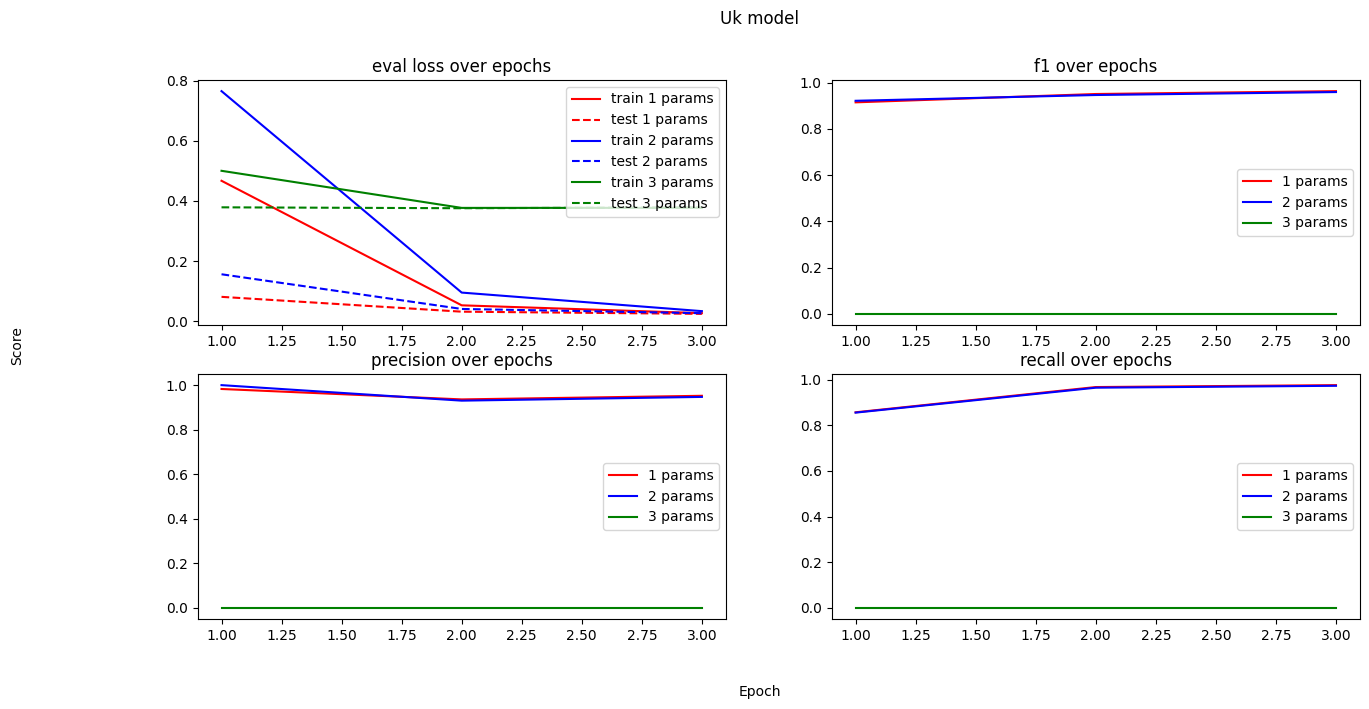

In [ ]:
print_stats(uk_metrics, title='Uk model')

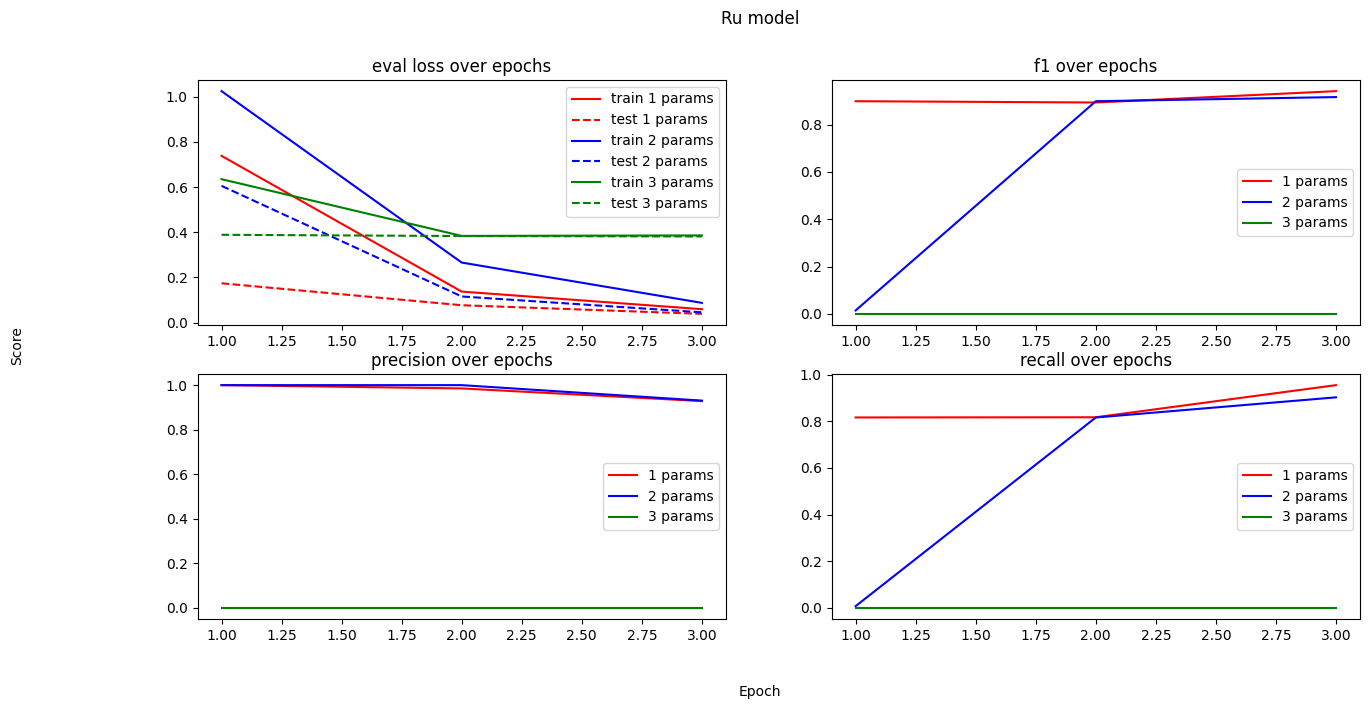

In [ ]:
print_stats(ru_metrics, title='Ru model')

As seen from the plots, cv with long and short warmup time have similar scores.
But with bigger dataset long warmup time can perform better, because model will
overfit less.

As for learning rate, having smaller lr for roberta model is much better.

## Training

Training model on joined uk and ru dataset, since competition data have both languages

In [ ]:
def get_train_args(name):
  return TrainingArguments(
      name,
      per_device_train_batch_size=64,
      per_device_eval_batch_size=64,
      evaluation_strategy='epoch',
      save_strategy='epoch',
      logging_strategy='epoch',
      num_train_epochs=3,
      fp16=True
  )

def train(model, train_dataset, test_dataset, args):
  opt, sched = get_opt_sched(
      model,
      1e-5,
      1e-3,
      0.75*(train_dataset.num_rows//64),
      3*(train_dataset.num_rows//64)
      )
  trainer = Trainer(
      model=model,
      args=args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      data_collator=data_collator,
      tokenizer=bert_tokenizer,
      compute_metrics=compute_metrics,
      optimizers=(opt, sched)
  )
  trainer.train()

In [ ]:
model = get_model()
train_args = get_train_args('roberta-loc')
train(
    model,
    concatenate_datasets([uk_train_processed_dataset, ru_train_processed_dataset]),
    concatenate_datasets([uk_holdout_processed_dataset, ru_holdout_processed_dataset]),
    train_args
    )

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.311900,0.017108,0.967276,0.992103,0.979532
2,0.018600,0.011844,0.970930,0.989141,0.979951
3,0.012700,0.010147,0.973684,0.986180,0.979892


## Kaggle submission

In [ ]:
checkpoint = 'roberta-loc/checkpoint-831'
classifier = pipeline(
    'token-classification', model=checkpoint, aggregation_strategy='simple'
)

In [ ]:
competition_test = pd.read_csv(DATA_DIR + 'competition/test.csv',
                               converters = {'locations': eval})
labeling_sample = pd.read_csv(DATA_DIR + 'competition/labeling_sample.csv',
                              converters = {'locations': eval})

In [ ]:
competition_test.head()

,text_id,text,locations
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[]
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...",[]
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,[]
3,3,Наразі у запасах росіян найбільше балістичних ...,[]
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...",[]


In [ ]:
labeling_sample.head()

,text,locations,loc_markers
0,-261.310,[],[]
1,"Проспект Бандери стоїть, як і пів міста… довго...",[Проспект Бандери],"[(0, 16)]"
2,☢️Радіаційний фон (мкР/год) по Київщині станом...,"[Київщині, Чорнобиль, Київ, Тетерів, Фастів, Б...","[(31, 39), (68, 77), (83, 87), (93, 100), (105..."
3,"Друзі. Останні дві ночі, і ще декілька наступн...",[проспекті Івасюка],"[(134, 151)]"
4,Сьогодні з Києва до Хелма вперше вирушив новий...,"[Києва, Хелма]","[(11, 16), (20, 25)]"


In [ ]:
competition_test['locations'] = [
    [p['word'] for p in s] for s in
    classifier(competition_test['text'].to_list())
]

In [ ]:
example_with_many_locations = competition_test.iloc[
    np.argsort(competition_test['locations'].apply(len)).iloc[-1]]

print(f"""
        Text: {example_with_many_locations['text']},
        Pred locations: {example_with_many_locations['locations']}
""")


        Text: Товар тижня та щасливі години від ТМ «Вареничок»
Наші магазини чекають на Вас:🤗
🥟проспект Миколи Бажана, 8, м-н NOVUS
🥟вул . Чорнобильська 13 (Академмістечко)
🥟вул.Святошинська 1,(біля м-ну NOVUS
🥟пр. Відрадний, 69/1, Відрадний
🥟бульв. Вацлава Гавела, 50, Відрадний
🥟смт. Козин , вул. А.Солов‘яненка 85А
🥟с. Хотянівка, вул.Валова 2В(м-нФора)
🥟вул. Хорива, 1-А, Поділ 
🥟вул. Кирилівська, 127, Куренівка
Наш сайт: https://varenychok.com.ua/
Интернет магазин: https://varenychok.ps.me/
ТК https://t.me/varenichok_ok,
        Pred locations: ['проспект Миколи Бажана, 8', '', 'US', 'вул', 'Чорнобильська 13', 'Академмістечко)', 'вул', 'Святошинська 1', 'US', 'пр.', 'Відрадний, 69/1', 'Відрадний ', 'бульв.', 'ацлава Гавела, 50', 'Відрадний', 'Козин', ',', 'вул.', '.', 'ов', 'яненка 85А', 'Хотянівка,', 'вул', 'Валова 2В', 'м-н', 'Фора)', 'вул', 'Хорива, 1-А', 'Поділ', 'вул', 'Кирилівська, 127', 'Куренівка']



In [ ]:
competition_test[['text_id', 'locations']].to_csv(
    DATA_DIR + 'competition/submission/roberta_uk_ru_small.csv', index=False)

## Competition score

Score after training model on 1% uk and 0.1% ru datasets for 3 epochs:

![roberta-score](images/roberta_score.png)

As seen from the score, fine-tuned transformer performed much better then regular rnn even after training on smaller dataset.